# Assignment 4

### Samuel Sheehy (Student ID 18143565)

### Techniques of High Performance Computing (PHAS0102)

### MSc Scientific Computing, University College London, 2019-2020

**This Jupyter Notebook is submitted as completion of the 4th Assignment for the UCL course cited above.**

## Contents
1. Introduction
2. Mathematical Derivation of Numerical Scheme
3. Organisation of Algorithm
4. Code
5. Choosing Parameters for Preconditioner
6. Analysis of Convergence
7. Concluding Remarks

## Introduction
This Jupyter Notebook numerically solves the following problem:

> _A square plate [−1, 1] × [−1, 1] is at temperature u = 0. At time $t$ = 0
the temperature is increased to $u = 5$ along one of the four sides while
being held at $u = 0$ along the other three sides, and heat then flows into
the plate according to $u_t = ∆u$_
>
>_When does the temperature reach $u = 1$ at the center of the plate?_
>
> In the Moment of Heat, **SIAM 100-Digit Challenge**

The solution is achieved by way of implementing a Crank-Nicholson, central difference
finite difference scheme on a 2-dimensional square of the above dimensions. The
scheme is implemented _via_ a combination of the techniques listed here:
* Linear Operators (OpenCL kernels) to apply the numerical scheme
* The Conjugate Gradient method to apply the inverse of a matrix
* A Preconditioner matrix formed through Sparse Incomplete LU decomposition
* Numba-accelerated Python for functions that do simple calculations
* The Secant Method for finding the solution to the problem



To cope with large system sizes, this Notebook also allows for the subdivision
of the problem to allow it to be solved in successive chiunks. This
ensures that the preconditioner matrix used is of a size that is manageable
by the machine when working with very large discretisiations.


## Mathematical Derivation of Numerical Scheme

Where $u_h$ is the numerical approximation of the solution $u$, $\tau$ is a small time step, $h$ is a small spatial step in either of the two spatial dimensions,  the scheme can be expressed mathematically as the following:

$$
u_h(t, x, y) = u_h(t - \tau, x, y) -  \frac{\tau}{2h^2} 
    \left[ 
        4 u_h(t - \tau, x, y)
        - u_h(t - \tau, x - h, y)
        - u_h(t - \tau, x + h, y)
        - u_h(t - \tau, x, y - h)
        - u_h(t - \tau, x, y + h)
      + 4 u_h(t, x, y)
        - u_h(t, x - h, y)
        - u_h(t, x + h, y)
        - u_h(t, x, y - h)
        - u_h(t, x, y + h)
    \right]
$$

Using $\alpha := \frac{\tau}{2h^2} $ and matching similar tearms we arrive at the following:

$$
(1 + 4\alpha)u_h(t, x, y) - \alpha[u_h(t, x - h, y) + u_h(t, x + h, y) + u_h(t, x, y - h) +  u_h(t, x, y + h)]
=
(1 - 4\alpha)u_h(t - \tau, x, y) +
\alpha[u_h(t - \tau, x - h, y) + u_h(t - \tau, x + h, y) + u_h(t - \tau, x, y - h) +  u_h(t - \tau, x, y + h)]
$$

Flattening the lattice row-wise and applying the boundary conditions $b$ gives the following linear system:

$$
A_{t+1}u_{h, n+1} = A_t u_{h, n} + 2\alpha b
$$


## Organisation of Algorithm
The algorithm for finding the solution follows this general algorithm:
1. Construct the Linear Operators $A_t$ and $A_{t+1}$ as OpenCL kernels
2. Construct the preconditioner $P$ to approximate the inverse of $A_{t+1}$
3. Use the secant method to approach the solution of problem.

Each iteration of the secant methods calculates the temperature at the
center of the plate reached after an elapsed time $t$. This is done by applying the
finite difference method above successively until the targetted time has been reached.
* _a_) Apply $u_h^* = A_t u_{h, n} + 2\alpha b$ 
* _b_) Solve $A_{t+1}u_{h, t+1} = u_h^* $ for $u_{h, t+1}$ using the Conjugate Gradient method
  with a preconditioner $P$.

## Setup

In [1]:
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from math import ceil
# import logging
import time

from scipy.sparse.linalg import LinearOperator, cg, spilu

import pyopencl as cl
from numba import njit

# The expected answer to 12 significant figures
TRUE_RESULT = 0.424011387033 

# Setting too small of spatial step size creates a preconditioner
# that is too large for a typical personal computer to handle
# to avoid crashing the system by accidentally setting too small
# of a value, this flag ensures the check of the step size.
LIMITED_SYSTEM = True


# logger = logging.getLogger('heat')
# logger.setLevel(logging.DEBUG)
# if not logger.handlers:
#     hdlr = logging.FileHandler('heat.log', mode='w', encoding='latin-1')
#     formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
#     hdlr.setFormatter(formatter)
#     logger.addHandler(hdlr) 
        

class Timer:
    """
    A simple timer class to measure the execution time
    of a function (seconds) in a ```with``` block.
    Taken from module lecture notes.
    """
    def __enter__(self):
        """
        Measure time at start.
        """
        self.start = time.time()
        return self

    def __exit__(self, *args):
        """
        Measure time at end and take difference
        from start.
        """
        self.end = time.time()
        self.interval = self.end - self.start
        

def bytesize(N, dtype_str):
    """
    Returns the number of bytes that an array of element
    size N occupies
    """
    return np.dtype(dtype_str).itemsize*N


def log(f):
    x = None
    try: 
#         logger.info(35*'-' + 'New Run' + 35*'-')
        with Timer() as t:
            ### Exec Code
            x = f()
            ###
#         logger.info(f'Total Run Time: {t.interval:.3E} s')
    except KeyboardInterrupt:
#         logger.error('Keyboard Interrupt')
        pass
    if x is not None:
        return x

## Code

In [2]:
 def show(b, R, C):
    """
    Display a colour plot image of the solution on the square.
    
    Boundary conditions must be included in the passed solution.
    
    Arguments
    ---------
    b -- the flattened solution to plot
    R -- the number of rows in the lattice
    C -- the number of columns in the lattice
    
    Returns nothing
    """
    p = b.reshape(R, C)

    # Display the solution
    plt.imshow(p, origin='lower')
    plt.colorbar()
    plt.title('Plot of Solution at time T')
    plt.show()
    
class FivePointStencil(LinearOperator):
    """
    Apply a 5-point stencil operator to a row-wise flattened
    lattice.
    """
    _openCL_code = """
    __kernel void matvec(
            __global double *vector,
            __global double *result,
            double alpha,
            double beta,
            double gamma,
            int XR,
            int XC
        )
        {        
        // Get Global Identifiers i.e. the row or col index
        int row_index = get_global_id(0); // offset by one to only look
        int col_index = get_global_id(1);    // at inner lattice
        
        
        // Determine boolean operators.
        // These decide if a particular term is active or not.
        int b1 = (int) (row_index + 1 != 1);   //bottom
        int b2 = (int) (row_index + 1 != XR); //top
        int b3 = (int) (col_index + 1 != 1);   //left
        int b4 = (int) (col_index + 1 != XC); //right
        
        int loc = row_index*XC + col_index;
        
        // Do stuff
        double product = alpha*vector[loc]              // center
                         + b1*beta*vector[b1*(loc-XC)] // bottom
                         + b2*beta*vector[b2*(loc+XC)] // top
                         + b3*beta*vector[b3*(loc-1)]   // left
                         + b4*beta*vector[b4*(loc+1)];  // right
    
        // Output answer
        result[loc] = product;
        }
    """
    def __init__(self, alpha, beta, XR, XC):
        """
        Initialise the OpenCL kernel with the given parameters.
        
        Arguments
        ---------
        alpha -- number to apply to central term
        beta  -- number to apply to neighbouring term
        XR    -- number of rows in the inner lattice
        XC    -- number of columns in the inner lattice
        
        Returns
        -------
        Linear Operator -- applies the numerical scheme to a flattened lattice
        """
        self.Mop = XR*XC
        self.shape = (self.Mop, self.Mop)
        self.XR = XR
        self.XC = XC
        self.dtype = np.dtype(np.float64)
        self.explicit = False
        self._vector_buffer = None
        self._result_buffer = None
        self.mapped_vector_buffer = None
        self.mapped_result_buffer = None
        self.alpha = alpha
        self.beta = beta
        self.c = 0
        self.offset = 0
        # Define kernel
        self._kernel = self._build_kernel()
    
    def _build_kernel(self):
        """
        Construct the kernel.
        """
        # Initialise the OpenCL environment
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.mf = cl.mem_flags
    
        # Create the buffer to hold the vector data
        self._vector_buffer = cl.Buffer(self.ctx, self.mf.ALLOC_HOST_PTR, bytesize(self.Mop, 'double'))

        # Create buffer to hold the result
        self._result_buffer = cl.Buffer(self.ctx, self.mf.ALLOC_HOST_PTR, size=bytesize(self.Mop, 'double'))
                                
        # Build the Kernel
        prg = cl.Program(self.ctx, FivePointStencil._openCL_code)
        prg.build()
        matvec_kernel = prg.matvec
        
        # Map Buffers
        self.mapped_vector_buffer, linking_event = cl.enqueue_map_buffer(
            self.queue, self._vector_buffer, cl.map_flags.WRITE, self.offset, self.Mop, np.double
        )
        linking_event.wait()

        self.mapped_result_buffer, linking_event = cl.enqueue_map_buffer(
            self.queue, self._result_buffer, cl.map_flags.READ,
            self.offset, self.Mop, np.double
        )
        linking_event.wait()
        
        return matvec_kernel
    
    def _exec_kernel(self, x, alpha, beta, c):
        """
        Execute the kernel with the given terms
        """
        # Rewrite vector buffer

        self.mapped_vector_buffer[:] = x    

        # Run the kernel
        self._kernel(
            # Workspace parameters
            self.queue, (self.XR, self.XC), None, # offset Ms to only look at inner lattice
            # Buffers
            self._vector_buffer, self._result_buffer,
            # Other parameters passed to kernel
            np.float64(alpha), np.float64(beta), np.float64(c), np.int32(self.XR), np.int32(self.XC)
        )

        fetched_result = self.mapped_result_buffer[:]
        self.queue.finish()
        return fetched_result

    def _matvec(self, x):
        """
        Apply the initialised operator to the given vector.
        """
        return self._exec_kernel(x, self.alpha, self.beta, self.c) 
    
@njit    
def get_system_size(h0):
    """
    Sets the number of discretisation points per side.
    
    Ensures the number of points is odd.
    """
    # Double the size of M since its dimensions corners
    # oppose themselves around the center.
    M = ceil(2/h0)
    # Ensure that M is odd so that there is a unique value
    # at its center.
    if M % 2 == 0:
        M += 1
    return M

@njit
def calibrate_h(M):
    """
    Redefine h to fit in system size.
    """
    return 2/M


def build_preconditioner(XR, XC, tau, h, dt, ff):
    """
    Create the preconditioner for the scheme.
    """""
    alpha = calc_alpha(tau, h)
    Mop = XR*XC
    At2 = build_sparse_matrix(XR, XC, 1 + 4*alpha, -alpha)
    P = create_preconditioner(At2, dt, ff)
    return P
    
@njit
def calc_alpha(tau, h):
    """
    Calculate alpha term - see equations in introduction
    """
    # Set stepping term
    alpha = tau/h**2/2
    return alpha

        
def build_sparse_matrix(XR, XC, alpha_center, alpha_edge):
    """
    Build a matrix which applies the Crank-Nicholsong finite difference
    scheme to solve the problem. This is used only to create the preconditioner.
    The operator for applying this is an OpenCl kernel.
    """
    data = []
    rows = []
    cols = []    
        
    # Determine the length of the operator
    M_op = XR*XC # Removes edges
    
    def add(datasource, val, row, colshift):
        """
        Add coefficient to operator.
        """
        datasource.append(val)
        rows.append(row)
        if row+colshift < 0:
            msg = f'Negative col index {row}: {colshift}'
#             logger.error(msg)
            raise Exception(msg)
        cols.append(row+colshift)
    
    k = 0
    for row_idx in range(0, XR):
        for col_idx in range(0, XC):            
            # center
            add(data, alpha_center, k, 0)
            
            # left
            if col_idx >= 1:
                add(data, alpha_edge, k, -1)
            
            # right
            if col_idx < XC - 1:
                add(data, alpha_edge, k, 1)
            
            # top
            if row_idx < XR - 1:
                add(data, alpha_edge, k, XC)
            
            # bottom
            if row_idx >= 1:
                add(data, alpha_edge, k, -XC)
            
            k += 1
            
    # Check for negative column indexes
    if any([x<0 for x in cols]):
        msg = f'Negative column index {i}'
#         logger.error(msg)
        raise Exception(msg)

    A = coo_matrix((data, (rows, cols))).tocsc()#.astype(np.float32)
    
    # Ensure matrix is square
    if A.shape[0] != A.shape[1]:
        msg = f'Matrix is not square: {A.shape}'
#         logger.error(msg)
        raise Exception(msg)
    
    # Ensure it's the expected size
    if A.shape[0] != M_op:
        msg = f'Matrix wrong size:{A.shape[0]}'
#         logger.error(msg)
        raise Exception(msg)

    return A


def build_operators(alpha, XR, XC):
    """
    Construct OpenCL kernels and box them in Linear Operators.
    """
    At  = FivePointStencil(1 - 4*alpha,  alpha, XR, XC)
    At2 = FivePointStencil(1 + 4*alpha, -alpha, XR, XC)
    return At, At2

@njit
def define_boundary_vector(bounds_top, bounds_bottom, alpha, XR, XC):
    """
    Translates the inluence of the boundary conditions into a vector
    that can be applied in the numerical scheme.
    """
    Mop = XR*XC
    b = np.zeros(Mop)
    k = 0
    for row_idx in range(XR):
        for col_idx in range(XC):
            # Consider Boundary influences
            # TOP
            if row_idx == XR-1:
                b[k] += bounds_top[col_idx]
            
            # BOTTOM
            if row_idx == 0:
                b[k] += bounds_bottom[col_idx]

            k += 1
    
    return b*alpha


def setup_system(XR, XC, h, tau, dt, ff):
    """
    Create the operators, preconditioner and boundary vector for the
    system.
    """
    # Get operators and boundary condition operator
    # this builds the matrix at every evaluation
    # Determine number of timesteps
#     logger.info(f'tau:{tau:.4E} - h:{h:.4E}')
#     logger.info(f'Drop factor: {dt} - Fill Factor: {ff}')
    with Timer() as t:
        At, At2, At2LOP, alpha = build_CN_system(M, tau, h)
#     logger.info(f'Built system in {t.interval:.3E} s')
#     logger.info(f'Matrix Size: {At.shape[0]}')
    
    with Timer() as t:
        P = create_preconditioner(At2, dt, ff)
    logger.info(f'Built preconditioner in {t.interval:.3E} s')
    
    return At, At2LOP, P, alpha


def advance_in_time(u_old, At, At2, P, bounds):
    """
    Advance the given subsystem by one timestep.
    """
    with Timer() as t1:
        u_temp = (At @ u_old + 2*bounds)
        
    with Timer() as t2:
        u_new, _ = faster_inversion_solve(At2, u_temp, P=P)
    
    return u_new, t1.interval, t2.interval


def advance_segmented(u_old, Nlist, params_lookup, alpha):
    """
    Advance the entire system by one timestep
    """
    prevN = 0
    Nprog = 1
    U = u_old
    T1 = 0
    T2 = 0
    for i, N in enumerate(Nlist):
        # setup
        XR, XC, At, At2, P = params_lookup[N]
#         print(U.shape, (Nprog-1)*XC, (Nprog)*XC)
        xbounds_bottom = U[(Nprog-1)*XC:(Nprog)*XC]
        xbounds_top = U[(Nprog+N)*XC:(Nprog+N+1)*XC]  
        bounds = define_boundary_vector(xbounds_top, xbounds_bottom, alpha, XR, XC)
        loc1 = (Nprog)*XC
        loc2 = (Nprog+N)*XC
        subU = U[loc1:loc2]
        # calc
        U[loc1:loc2], dT1, dT2 = advance_in_time(subU, At, At2, P, bounds)
        # prep for next
        Nprog += N
        prevN = N
        T1 += dT1
        T2 += dT2
    return U, T1, T2


def build_segmented(M, tau, h, n_segments, dt, ff):
    """
    Section the lattice into bands and build the respective operators
    and preconditioners for each bands.
    """
    # Define Band sizes, N is the number of rows in a band
    Nsize = (M-2)//n_segments
    Nlist = [Nsize if i != n_segments - 1 else Nsize+((M-2)%Nsize) for i in range(n_segments)]
    Nuniq = list(set(Nlist))
    
    alpha = calc_alpha(tau, h)
    # Define boundary conditions here
    bounds_top = np.ones(M-2)*0
    bounds_bottom = np.ones(M-2)*5
    # Define System Size
    OR = M # number of rows
    OC = M - 2 # number of coluumns
#     logger.info(f'Building system. M={M}, N={Nlist}, alpha={alpha}, System Size:{OR*OC}')
    
    params_lookup = {}
    for N in Nuniq:
        XR = N
        XC = OC
#         logger.debug(f'Subsystem Size for N={N}: {XR*XC}')
        At, At2 = build_operators(alpha, XR, XC)
        P = build_preconditioner(XR, XC, tau, h, dt, ff)
        params_lookup[N] = (XR, XC, At, At2, P)
    return Nlist, params_lookup, bounds_top, bounds_bottom, alpha


def temp_at_time(Uinit, T_target0, T_target1, Nlist, params_lookup, tau, alpha, OR, OC):
    """
    Calculates the temperature at the central point at a given
    time t, according to a spacial step h and a time step tau.
    """    
    T1 = 0
    T2 = 0
    # Initialise the estimate for the lattice solution
    Uf = [Uinit.copy(), Uinit.copy()] # Copy the system to avoid inplace operations
    u = Uf[0]
    
    # Determine the smaller target and get there indexes
    T_target = [T_target0, T_target1]
    rank_min = int(min(T_target) != T_target0)
    rank_max = int(not rank_min)
#     logger.debug(f'T_target values are {T_target[0]} and {T_target[1]}')
#     logger.debug(f'The smallest is at index {rank_min}, the largest at {rank_max}')

    # Effectuate iteration until time reached
#     logger.debug('Beginning time stepping...')
    k = 0
    while k*tau < T_target[rank_min]:
        u, dT1, dT2 = advance_segmented(u, Nlist, params_lookup, alpha)
        T1 += dT1
        T2 += dT2
        k += 1
    Uf[rank_min] = u.copy()
    while k*tau < T_target[rank_max]:
        u, dT1, dT2 = advance_segmented(u, Nlist, params_lookup, alpha)
        T1 += dT1
        T2 += dT2
        k += 1
    Uf[rank_max] = u
    
#     logger.info(f'RHS Op: {T1:.2E} s - Inversion: {T2:.2E}')
    
    return Uf


def secant_method(f, rhs, x0, x1, tol, maxiter=1000):
    """
    Using the secant method, solve the system f(x) = rhs.
    """
    # Initiate parameters
    def fzero(x0, x1): 
        f0, f1 = f(x0, x1)
        return f0 - rhs, f1 - rhs
    x_1 = x1
    x_0 = x0
    k = 0
    # Iterate
    while abs(x_1 - x_0) > tol and k < maxiter:
        f0, f1 = fzero(x_0, x_1)
#         logger.debug(f'f0: {f0}; f1:{f1}')
        if f0 == f1:
#             logger.debug('Solutions in secant search f0 and f1 are equal so finishing search')
            break
        x_new = x_1 - f1*(x_1 - x_0)/(f1 - f0)
        x_0 = x_1
        x_1 = x_new
        k += 1
#         logger.info(f'New estimate for solution: {x_new}')
    
    if k >= maxiter:
#         logger.warning(f'Solver exited before finding a solution. k is {k}')
        pass
    else:
#         logger.info(f'Secant method converged in {k} iterations')
        pass
    return x_new

@njit
def get_center_value(u):
    """
    Return the value at the center of the lattice
    """
    return u[len(u)//2]


def center_temp_at_time(Uinit, t0, t1, Nlist, params_lookup, tau, alpha, OR, OC):
    """
    Determine the temparature at the center of the lattice
    at the time t for th given step sizes h and tau.
    """
    u0, u1 = temp_at_time(Uinit, t0, t1, Nlist, params_lookup, tau, alpha, OR, OC)
    center0 = get_center_value(u0)
    center1 = get_center_value(u1)
    return center0, center1

    
def main_solve(T, h0, tau, tol, dt, ff, x0, x1, n_segments):
    """
    Determine the solution of the initial problem.
    """
#     logger.info(f'Starting solve with x0: {x0} and x1:{x1}')
    
    M = get_system_size(h0)
    h = calibrate_h(M)
    
    OR = M
    OC = M - 2
    
    Nlist, params_lookup, bounds_top, bounds_bottom, alpha = build_segmented(M, tau, h, n_segments, dt, ff)
    
    # Set initial conditions for the lattice space
    Uinit = np.ones(OR*OC)*0
    Uinit[0:OC] = bounds_bottom[:]
    Uinit[OC*(OR-1):OR*OC] = bounds_top[:]    
    f = lambda t0, t1: center_temp_at_time(Uinit, t0, t1, Nlist, params_lookup, tau, alpha, OR, OC)
    with Timer() as t:
        center_T = secant_method(f, T, x0, x1, tol)
#     logger.info(f'Secant method complete in {t.interval:.2E} s')
#     logger.info(f'Solution is {center_T}')
    return center_T


def create_preconditioner(A, dt, ff):
    """
    Using SPILU and a specified drop tolerance, create a preconditioner
    for A.
    """
    ilu = spilu(A, drop_tol=dt, fill_factor=ff)
    Mx = lambda x: ilu.solve(x.astype(np.float32))
    N = A.shape[0]
    P = LinearOperator((N, N), Mx)
    return P


def faster_inversion_solve(A, b, P=None, maxiter=100):
    """
    Solve the sysem Ax = b for x.
    """
    history = []
    def error_calc(u):
        """
        Local function to exctract error from plot.
        """
        error = np.linalg.norm(A@u - b)
        history.append(error)
    x, info = cg(A, b, callback=error_calc, M=P, maxiter=maxiter)
    # Check convergence status of solution
    if info > 0:
#         logger.warning(f'Did not converge! i={info}')
        pass
    if info < 0:
#         logger.error(f'There was an error in cg at i={info}')
        raise Exception('CG failed')
    return x, history

## DEMO: Running the Code
### Test 1
In this section we briefly show the code in action. First by checking the accuracy of the
function ```temp_at_time``` with the known solution to the problem. We expect the
result to be $1$.

When setting $\tau = 10^{-4}$ and $h = 5 \times 10^{-3}$, this function
finds the temperature at the center of the plate at the time of the exact solution
to be 1.0027156, signfying an error of 2.7156E-03.

_Note_ : My experimentation with step sizes was limited by the processing power
of my computer. Computing times proved too large for systems with a stepsize
$h$ less than $5 \times 10^{-3}$

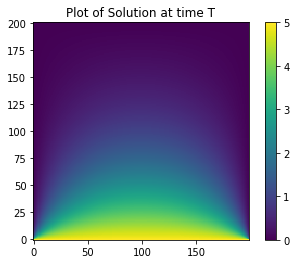

At time t=0.424011... seconds, the center temperature is 1.0063884459264785
This signifies an error of 6.3884E-03 from the known solution.


1.0063884459264785

In [3]:
TAU = 1e-3
H = 1e-2

def test_temp_to_time(tau, h0):
    """
    Test the function to estimate the temperature at the center after
    a set amount of time has elapsed.
    
    The function accepts to time targets and returns the estimate for
    both of them. This allows for more efficient implementation of the secant
    method.
    """
#     logger.info('Begin Test: temp_to_time')
    Ttarget = TRUE_RESULT
    if h0 <5e-3 and LIMITED_SYSTEM:
        print('Warning! This might create a preconditioner too large for your machine to handle.')
        print('Change LIMITED_SYSTEM to False to diable this check.')
        print('Aborting')
        return
    # Preconditioner parameters
    drop_tol = 1e-5
    fill_fact = 20

    n_segments = 1  # Segmentisation of the system. Instructs the algorithm
                    # to solve in the given amount of chunks - keep as low 
                    # as the machine can handle for best accuracy.
            
    # Determine corrsponding system size for preffered step size and recalibrate h
    M = get_system_size(h0)
    h = calibrate_h(M)
    OR = M     # Set system dimensions
    OC = M - 2 # This algorithm does not allow for non-zero boundary conditions on the
               # left or right edges of the system
#     logger.info(f'tau={tau}; h={h}')
    
    # Execute build of system
    system = build_segmented(M, tau, h, n_segments, drop_tol, fill_fact)
    Nlist, params_lookup, bounds_top, bounds_bottom, alpha = system # unpack
    
    # Set the initial conditions and top and bottom boundary conditions
    Uinit = np.ones(OR*OC)*0
    Uinit[0:OC] = bounds_bottom[:]
    Uinit[OC*(OR-1):OR*OC] = bounds_top[:]
    
    # Caclulate temperature at time Ttarget
    U0, U1 = temp_at_time(Uinit, 0, Ttarget, Nlist, params_lookup, tau, alpha, OR, OC)
    
#     logger.debug(f'At t={Ttarget}, center-T={get_center_value(U1)}')

    return U1, OR, OC
        
        
u, nrows, ncols = log(lambda: test_temp_to_time(TAU, H))
show(u, nrows, ncols)
ans = get_center_value(u)
print('At time t=0.424011... seconds, the center temperature is', ans)
print(f'This signifies an error of {abs(1-ans):.4E} from the known solution.')
ans # return answer

### Test 2
Second, we check the accuracy of the full-problem solver ```main_solve```.

Using $\tau = 10^{-4}$ and $h = 5 \times 10^{-3}$, we find that the center of the plate reaches the temperature 1 at 0.4218282416570489 seconds, signifying an error of 2.1831E-03 from
the known exact solution.

In [ ]:
# Solve
TAU = 5e-4
H = 8e-3

def test_main_solve(tau, h):
    # Setup

    dt = 1e-5
    ff = 20
    tol = 1e-3
    x0 = 0.42
    x1 = 0.43
    T = 1
    n_segments = 1
#     logger.info('Begin Time to 1 Test')
#     logger.info(f'tau={tau}; h={h}')
    estimate = main_solve(T, h, tau, tol, dt, ff, x0, x1, n_segments)
#     logger.info(f'Time to reach {T} is {estimate} s, tol={tol:.2E}' )
    return estimate

try:
    estimate = log(lambda: test_main_solve(TAU, H))
except Exception as e:
#     logger.error('%s'%e)
    raise e

# Error
print(f'Time to 1: {estimate}\nError from correct solution is {abs(estimate - TRUE_RESULT): .4E}')
estimate

## Choosing Parameters for Preconditioner

The preconditioner for this solver uses the Sparse Incomplete LU decomposition
feature of the SciPy library. To find good valus for the drop tolerance
and fill factor parameters for the generator, we measure the performance
for a small sample various parameters and choose ones that give good
convergence results. This is done below.

The analysis indicates that a drop tolerance of $1 \times 10^-5$ and a fill
factor of $18$ would provide good convergence results.

In [ ]:
def study_ilu_convergence(h, tau, drop_tol_list, fill_fact_list):
    """
    For a system of size h, apply Scipy's ILU rountine
    for various drop factors and compare the rates of convergence for each
    run.
    """
    M = get_system_size(h)
    h = calibrate_h(M)
    XR = M
    XC = M - 2
    alpha = calc_alpha(tau, h)
    _, At2 = build_operators(alpha, XR, XC)
    b = np.ones(At2.shape[0])
    convergences = np.zeros((len(drop_tol_list), len(fill_fact_list)))
    for i, dt in enumerate(drop_tol_list):
        for j, ff in enumerate(fill_fact_list):
            P = build_preconditioner(XR, XC, tau, h, dt, ff)
            sol, history = faster_inversion_solve(At2, b, P, maxiter=200)
            convergences[i, j] = len(history)
    
    convergences[convergences==200]=np.nan # set to NaN the ones that did not converge
                                        # quickly enough

    return convergences


def plot_convergences(convergences, droptols, fillfacts):
    """
    Plots the results from the convergence measurements
    """
    print('drop tolerances:', ['%.2E'%dt for dt in droptols])
    print('fill factors:', [ff for ff in fill_factors])
    plt.imshow(
        convergences
    )
    plt.xlabel('fill factor list index')
    plt.ylabel('drop tolerance list index')
    plt.title('Comparison of Convergence for Various Drop Factors and Fill Factors')
#     plt.legend(loc='upper right')
    plt.colorbar()
    fig = plt.gcf()
    fig.dpi = 100
    plt.show()

# Saved Results
nan = np.nan
_c = np.array(
      [[nan, nan, 18., 18., 18., 18., 18., 18., 18., 18.],
       [nan, nan, nan, nan,  7.,  7.,  7.,  7.,  7.,  7.],
       [nan, nan, nan, nan, nan,  4.,  4.,  4.,  4.,  4.],
       [nan, nan, nan, nan, nan, nan,  3.,  3.,  3.,  3.],
       [nan, nan, nan, nan, nan, nan, nan,  2.,  2.,  2.],
       [nan, nan, nan, nan, nan, nan, nan, nan,  2.,  2.],
       [nan, nan, nan, nan, nan, nan, nan, nan,  2.,  2.],
       [nan, nan, nan, nan, nan, nan, nan, nan, 70.,  2.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan,  2.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan,  1.]]
)

droptols = 10**np.linspace(-2, -8, 10)
fill_factors = np.linspace(5, 20, 10)
# Unomment/Comment to disable/enable the calculation
# _c = study_ilu_convergence(1e-2, 1e-2, droptols, fill_factors)
plot_convergences(_c, droptols, fill_factors)

## Analysis of Convergence

The plots below illustrate the convergence behaviour of the method
according to both the spatial and temporal step sizes. We note the
exponential convergence through both parameters as expected for
the temporal solution through the implementation of the Crank-
Nicolson scheme, and the spatial solution through the central difference
scheme.

In [ ]:
def analyse_convergence(tau_list, h_list):
    sol = np.zeros((len(tau_list), len(h_list)))
    for i, tau in enumerate(tau_list):
        for j, h in enumerate(h_list):
            if tau <=  h:
                sol[i, j] = test_main_solve(tau, h)
            else:
                sol[i, j] = np.nan
    return sol

results = np.array([
    [0.39612304, 0.40598509, 0.41942498,        nan,        nan],
    [0.40070628, 0.41167884, 0.41955515, 0.4183998 , 0.41894067],
    [0.40307709, 0.4129128 , 0.41959246, 0.42069827, 0.42185341],
    [0.40328405, 0.41345318, 0.41959111, 0.42069791, 0.42183853],
    [0.40372472, 0.41535924, 0.41980078, 0.42079916, 0.42182824]]
)
            
tau_list = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
h_list = [5e-2, 2.5e-2, 1e-2, 7.5e-3, 5e-3]
# results = log(lambda: analyse_convergence(tau_list, h_list))

### Plotting
plt.imshow(abs(results - TRUE_RESULT))
plt.colorbar()
plt.xlabel('Decreasing Time Step')
plt.ylabel('Descreasing Space Step')
plt.title('Error of Results for Various Step Sizes')
plt.show()

plt.semilogy(tau_list, results[2, :], '.-')
plt.xlabel('Time Step')
plt.ylabel('Error of Result')
plt.title('Convergence of Result with fixed Space Step and Variable Time Step')
plt.show()

plt.semilogy(h_list, results[:, 1], '.-')
plt.xlabel('Space Step')
plt.ylabel('Error of Result')
plt.title('Convergence of Result with fixed Time Step and Variable Space Step')
plt.show()

## Concluding Remarks

The method above would potentially allow the resolution of the problem to any
degree of accuracy if the requirements in terms of system size and calculation
speed could be met.